In [3]:
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, FloatSlider

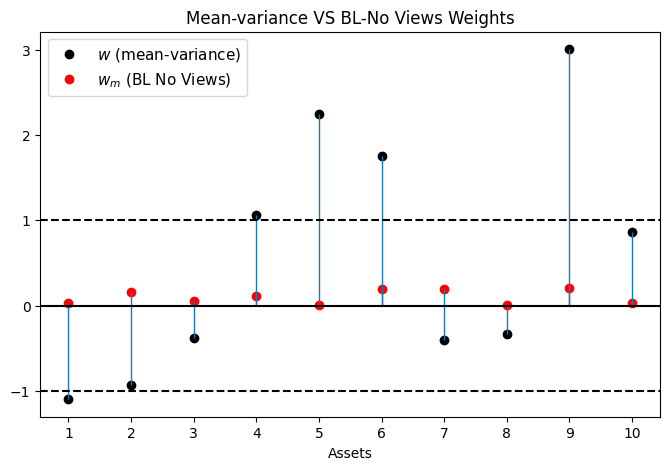

In [4]:
np.random.seed(12)

N = 10                                           # Number of assets
T = 200                                          # Sample size

# random market portfolio (sum is normalized to 1)
w_m = np.random.rand(N)
w_m = w_m / (w_m.sum())

# True risk premia and variance of excess return (constructed
# so that the Sharpe ratio is 1)
μ = (np.random.randn(N) + 5)  /100      # Mean excess return (risk premium)
S = np.random.randn(N, N)        # Random matrix for the covariance matrix
V = S @ S.T           # Turn the random matrix into symmetric psd
# Make sure that the Sharpe ratio is one
Σ = V * (w_m @ μ)**2 / (w_m @ V @ w_m)

# Risk aversion of market portfolio holder
δ = 1 / np.sqrt(w_m @ Σ @ w_m)

# Generate a sample of excess returns
excess_return = stat.multivariate_normal(μ, Σ)
sample = excess_return.rvs(T)

# Estimate μ and Σ
μ_est = sample.mean(0).reshape(N, 1)
Σ_est = np.cov(sample.T)

w = np.linalg.solve(δ * Σ_est, μ_est)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Mean-variance VS BL-No Views Weights')
ax.plot(np.arange(N)+1, w, 'o', c='k', label='$w$ (mean-variance)')
ax.plot(np.arange(N)+1, w_m, 'o', c='r', label='$w_m$ (BL No Views)')
ax.vlines(np.arange(N)+1, 0, w, lw=1)
ax.vlines(np.arange(N)+1, 0, w_m, lw=1)
ax.axhline(0, c='k')
ax.axhline(-1, c='k', ls='--')
ax.axhline(1, c='k', ls='--')
ax.set_xlabel('Assets')
ax.xaxis.set_ticks(np.arange(1, N+1, 1))
plt.legend(numpoints=1, fontsize=11)
plt.show()

Using the same input we see that, mean variance has extreme deviations from market portfolio.

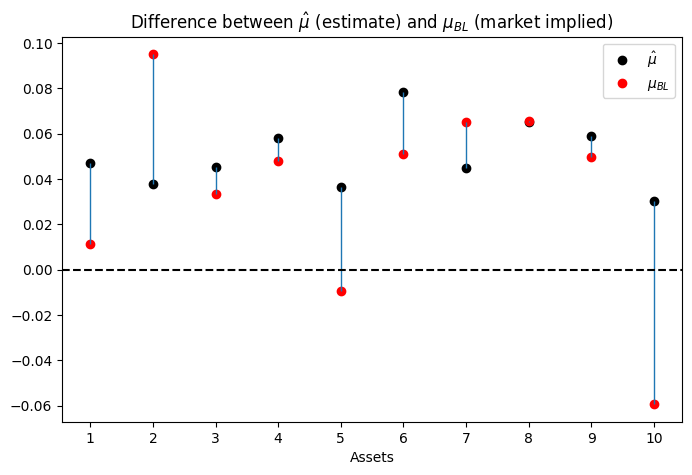

In [5]:
# Observed mean excess market return
r_m = w_m @ μ_est

# Estimated variance of the market portfolio
σ_m = w_m @ Σ_est @ w_m

# Sharpe-ratio
sr_m = r_m / np.sqrt(σ_m)

# Risk aversion of market portfolio holder
d_m = r_m / σ_m

# Derive "view" which would induce the market portfolio
μ_m = (d_m * Σ_est @ w_m).reshape(N, 1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title(r'Difference between $\hat{\mu}$ (estimate) and $\mu_{BL}$ (market implied)')
ax.plot(np.arange(N)+1, μ_est, 'o', c='k', label='$\hat{\mu}$')
ax.plot(np.arange(N)+1, μ_m, 'o', c='r', label='$\mu_{BL}$')
ax.vlines(np.arange(N) + 1, μ_m, μ_est, lw=1)
ax.axhline(0, c='k', ls='--')
ax.set_xlabel('Assets')
ax.xaxis.set_ticks(np.arange(1, N+1, 1))
plt.legend(numpoints=1)
plt.show()

In [6]:
def black_litterman(λ, μ1, μ2, Σ1, Σ2):
    """
    This function calculates the Black-Litterman mixture
    mean excess return and covariance matrix
    """
    Σ1_inv = np.linalg.inv(Σ1)
    Σ2_inv = np.linalg.inv(Σ2)

    μ_tilde = np.linalg.solve(Σ1_inv + λ * Σ2_inv,
                              Σ1_inv @ μ1 + λ * Σ2_inv @ μ2)
    return μ_tilde

τ = 1
μ_tilde = black_litterman(1, μ_m, μ_est, Σ_est, τ * Σ_est)

# The Black-Litterman recommendation for the portfolio weights
w_tilde = np.linalg.solve(δ * Σ_est, μ_tilde)

τ_slider = FloatSlider(min=0.05, max=10, step=0.5, value=τ)

@interact(τ=τ_slider)
def BL_plot(τ):
    μ_tilde = black_litterman(1, μ_m, μ_est, Σ_est, τ * Σ_est)
    w_tilde = np.linalg.solve(δ * Σ_est, μ_tilde)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(np.arange(N)+1, μ_est, 'o', c='k',
               label=r'$\hat{\mu}$ (subj view)')
    ax[0].plot(np.arange(N)+1, μ_m, 'o', c='r',
               label=r'$\mu_{BL}$ (market)')
    ax[0].plot(np.arange(N)+1, μ_tilde, 'o', c='y',
               label=r'$\tilde{\mu}$ (mixture)')
    ax[0].vlines(np.arange(N)+1, μ_m, μ_est, lw=1)
    ax[0].axhline(0, c='k', ls='--')
    ax[0].set(xlim=(0, N+1), xlabel='Assets',
              title=r'Relationship between $\hat{\mu}$, $\mu_{BL}$, and  $ \tilde{\mu}$')
    ax[0].xaxis.set_ticks(np.arange(1, N+1, 1))
    ax[0].legend(numpoints=1)

    ax[1].set_title('Black-Litterman portfolio weight recommendation')
    ax[1].plot(np.arange(N)+1, w, 'o', c='k', label=r'$w$ (mean-variance)')
    ax[1].plot(np.arange(N)+1, w_m, 'o', c='r', label=r'$w_{m}$ (market, BL)')
    ax[1].plot(np.arange(N)+1, w_tilde, 'o', c='y',
               label=r'$\tilde{w}$ (mixture)')
    ax[1].vlines(np.arange(N)+1, 0, w, lw=1)
    ax[1].vlines(np.arange(N)+1, 0, w_m, lw=1)
    ax[1].axhline(0, c='k')
    ax[1].axhline(-1, c='k', ls='--')
    ax[1].axhline(1, c='k', ls='--')
    ax[1].set(xlim=(0, N+1), xlabel='Assets',
              title='Black-Litterman portfolio weight recommendation')
    ax[1].xaxis.set_ticks(np.arange(1, N+1, 1))
    ax[1].legend(numpoints=1)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='τ', max=10.0, min=0.05, step=0.5), Output()), _dom_c…